# DATA PREPROCESSING

In [1]:
!pip install fairlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from fairlearn.metrics import selection_rate
import kagglehub
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import DataCollatorWithPadding
from tqdm import tqdm
from IPython.display import FileLink
from datasets import Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.2 MB/s eta 0:00:0000:01


2025-05-31 15:47:49.216958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748706469.421870      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748706469.482982      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv("/kaggle/input/ethics-amazon-reviewdataset/train.csv")
df_val = pd.read_csv("/kaggle/input/ethics-amazon-reviewdataset/validation.csv")
df_test = pd.read_csv("/kaggle/input/ethics-amazon-reviewdataset/test.csv")

In [3]:
def clean_and_check_nulls(df, name="Dataset"):
    original_len = len(df)
    df = df.dropna(subset=['review_title'])
    dropped = original_len - len(df)
    print(f"{name}: Dropped {dropped} rows with null 'review_title'.")
    
    remaining_nulls = df.isnull().sum()
    if remaining_nulls.sum() == 0:
        print(f"{name}: No remaining nulls.")
    else:
        print(f"{name}: Remaining null values:\n{remaining_nulls[remaining_nulls > 0]}")
    
    return df

In [4]:
def preprocess_data(df):
    df = clean_and_check_nulls(df);
    df['review'] = df.apply(
        lambda x: f"CATEGORY: {x['product_category']}\nTITLE: {x['review_title']}\nREVIEW TEXT: {x['review_body']}",
        axis=1
    )
    df = df[df['language'].isin(['en', 'de', 'es'])]
    df = df[df['stars'] != 3]
    df["label"] = df["stars"].apply(lambda x: 1 if x >= 4 else 0)
    df_en = df[df['language'] == 'en']
    df_de = df[df['language'] == 'de']
    df_es = df[df['language'] == 'es']
    
    return df, df_en, df_de, df_es

In [5]:
df_train, df_train_en, df_train_de, df_train_es = preprocess_data(df_train)

Dataset: Dropped 43 rows with null 'review_title'.
Dataset: No remaining nulls.


/tmp/ipykernel_35/3457969799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df.apply(


In [6]:
df_train = df_train[["review", "label"]]
print("Train shape:", df_train.shape)

df_train_en = df_train_en[["review", "label"]]
print("Train EN shape:", df_train_en.shape)

df_train_de = df_train_de[["review", "label"]]
print("Train DE shape:", df_train_de.shape)

df_train_es = df_train_es[["review", "label"]]
print("Train ES shape:", df_train_es.shape)

Train shape: (479978, 2)
Train EN shape: (159978, 2)
Train DE shape: (160000, 2)
Train ES shape: (160000, 2)


In [7]:
df_val, df_val_en, df_val_de, df_val_es = preprocess_data(df_val)
df_val = df_val[["review", "label"]]
print("Validation shape:", df_val.shape)

df_val_en = df_val_en[["review", "label"]]
print("Validation EN shape:", df_val_en.shape)

df_val_de = df_val_de[["review", "label"]]
print("Validation DE shape:", df_val_de.shape)

df_val_es = df_val_es[["review", "label"]]
print("Validation ES shape:", df_val_es.shape)


Dataset: Dropped 2 rows with null 'review_title'.
Dataset: No remaining nulls.
Validation shape: (11998, 2)
Validation EN shape: (3999, 2)
Validation DE shape: (3999, 2)
Validation ES shape: (4000, 2)


/tmp/ipykernel_35/3457969799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df.apply(


In [8]:
df_test, df_test_en, df_test_de, df_test_es = preprocess_data(df_test)
df_test = df_test[["review", "label", "product_category", "language"]]
print("Test shape:", df_test.shape)

df_test_en = df_test_en[["review", "label", "product_category", "language"]]
print("Test EN shape:", df_test_en.shape)

df_test_de = df_test_de[["review", "label", "product_category", "language"]]
print("Test DE shape:", df_test_de.shape)

df_test_es = df_test_es[["review", "label", "product_category", "language"]]
print("Test ES shape:", df_test_es.shape)

Dataset: Dropped 1 rows with null 'review_title'.
Dataset: No remaining nulls.
Test shape: (11999, 4)
Test EN shape: (3999, 4)
Test DE shape: (4000, 4)
Test ES shape: (4000, 4)


/tmp/ipykernel_35/3457969799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df.apply(


In [9]:
model_name = "google-bert/bert-base-multilingual-cased"
num_epochs = 3
learning_rate = 2e-4
weight_decay = 0.01
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [11]:
def custom_collate_fn(batch):
    languages = [item["language"] for item in batch]
    batch_without_language = [{k: v for k, v in item.items() if k != "language"} for item in batch]
    collated_batch = data_collator(batch_without_language)
    collated_batch["language"] = languages
    return collated_batch


def prepare_datasets(df_train, df_val, df_test, only_test=False):
    if only_test:
        test_dataset = Dataset.from_pandas(df_test.reset_index(drop=True))
        test_dataset = test_dataset.map(
            lambda e: tokenizer(e["review"], truncation=True, padding="max_length", max_length=512),
            batched=True
        )
        test_dataset.set_format(type=None, columns=["input_ids", "attention_mask", "label", "language"])

        test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
        return test_loader

    else:
        train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
        train_dataset = train_dataset.map(lambda e: tokenizer(e["review"], truncation=True, padding="max_length", max_length=512), batched=True)
        train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
        
        val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))
        val_dataset = val_dataset.map(lambda e: tokenizer(e["review"], truncation=True, padding="max_length",max_length=512), batched=True)
        val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
    
        return train_loader, val_loader

In [12]:
def prepare_model():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                               num_labels=2,
                                                               torch_dtype=torch.float32
                                                              ).to(device)
    for param in model.base_model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
    return model

In [13]:
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader, val_loader, EPOCHS, save_path):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()
    
    best_f1 = 0.0
    
    for epoch in range(EPOCHS): 
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
    
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
    
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
    
        print(f"Epoch {epoch + 1} - Training loss: {total_loss / len(train_loader):.4f}")
    
        model.eval()
        all_preds, all_labels = [], []
    
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
    
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
    
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
    
        print(f"Epoch {epoch + 1} - Loss: {total_loss / len(train_loader):.4f} | Val Acc: {acc:.4f} | Val F1: {f1:.4f}")
    
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved (F1: {f1:.4f})")

In [14]:
def compute_fairness_metrics(y_true, y_pred, group_name=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    epsilon = 1e-10

    statistical_parity = (tp + fp) / (tp + fp + tn + fn + epsilon)
    equality_of_opportunity = tp / (tp + fn + epsilon)
    calibration_pos = tp / (tp + fp + epsilon)
    calibration_neg = tn / (tn + fn + epsilon)
    conditional_use_error_pos = fp / (tp + fp + epsilon)
    conditional_use_error_neg = fn / (tn + fn + epsilon)
    treatment_equality_fp_fn = fp / (fn + epsilon) if fn != 0 else 0
    treatment_equality_fn_fp = fn / (fp + epsilon) if fp != 0 else f0
    
    print(f"\nFairness Metrics ({group_name})")
    print(f"Statistical Parity             : {statistical_parity:.4f}")
    print(f"Equality of Opportunity        : {equality_of_opportunity:.4f}")
    print(f"Calibration (Pos)              : {calibration_pos:.4f}")
    print(f"Calibration (Neg)              : {calibration_neg:.4f}")
    print(f"Conditional Use Error (P)      : {conditional_use_error_pos:.4f}")
    print(f"Conditional Use Error (N)      : {conditional_use_error_neg:.4f}")
    print(f"Treatment Equality (FP/FN)     : {treatment_equality_fp_fn:.4f}")
    print(f"Treatment Equality (FN/FP)     : {treatment_equality_fn_fp:.4f}")

    return {
        "statistical_parity": statistical_parity,
        "equality_of_opportunity": equality_of_opportunity,
        "calibration_pos": calibration_pos,
        "calibration_neg": calibration_neg,
        "conditional_use_error_pos": conditional_use_error_pos,
        "conditional_use_error_neg": conditional_use_error_neg,
        "treatment_equality_fp_fn": treatment_equality_fp_fn,
        "treatment_equality_fn_fp": treatment_equality_fn_fp
    }


In [15]:
def test_model(model, test_loader, model_id, lang_code=None):
    
    y_pred, y_true, group_labels, results_table = [], [], [], []
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            languages = batch['language']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)
            
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            group_labels.extend(languages)
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix: {model_id} ({lang_code or 'all'})")
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    sel_rate = selection_rate(y_true, y_pred)

    print("")
    print(f"\nAccuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Selection Rate: {sel_rate:.4f}")

    fairness_metrics = compute_fairness_metrics(y_true, y_pred, group_name=f"{model_id} ({lang_code or 'all'})")

    entry = {
        "model": model_id,
        "lang": lang_code or "all",
        "accuracy": acc,
        "f1_score": f1,
        "selection_rate": sel_rate,
        **fairness_metrics
    }
    results_table.append(entry)

    return y_pred, results_table

# ENGLISH

In [16]:
train_loader_en, val_loader_en = prepare_datasets(df_train_en, df_val_en, df_test_en)

Map:   0%|          | 0/159978 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

In [17]:
model_en = prepare_model()

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [18]:
#train_model(model_en, train_loader_en, val_loader_en, num_epochs, "./best_model_en.pt")

In [19]:
#!zip -r best_model_en.zip /kaggle/working/best_model_en.pt

In [20]:
#FileLink(r'best_model_en.zip')

In [21]:
state_dict = torch.load("/kaggle/input/bert_base_model_en/transformers/default/1/best_model_en.pt")
model_en.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
test_loader_en = prepare_datasets(None, None, df_test_en, True)

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 16/16 [01:52<00:00,  7.04s/batch]


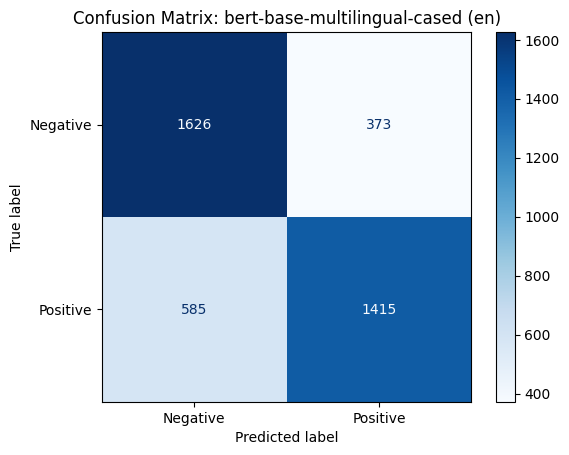



Accuracy: 0.7604
F1 Score: 0.7471
Selection Rate: 0.4471

Fairness Metrics (bert-base-multilingual-cased (en))
Statistical Parity             : 0.4471
Equality of Opportunity        : 0.7075
Calibration (Pos)              : 0.7914
Calibration (Neg)              : 0.7354
Conditional Use Error (P)      : 0.2086
Conditional Use Error (N)      : 0.2646
Treatment Equality (FP/FN)     : 0.6376
Treatment Equality (FN/FP)     : 1.5684


In [23]:
all_labels_en, results_table = test_model(model_en, test_loader_en, "bert-base-multilingual-cased", "en")

# GERMAN

In [24]:
train_loader_de, val_loader_de = prepare_datasets(df_train_de, df_val_de, df_test_de)

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

In [25]:
model_de = prepare_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [26]:
#train_model(model_de, train_loader_de, val_loader_de, num_epochs, "./best_model_de.pt")

In [27]:
#!zip -r best_model_de.zip /kaggle/working/best_model_de.pt

In [28]:
#FileLink(r'best_model_de.zip')

In [29]:
state_dict = torch.load("/kaggle/input/bert_best_model_de/transformers/default/1/best_model_de.pt")
model_de.load_state_dict(state_dict)

<All keys matched successfully>

In [30]:
test_loader_de = prepare_datasets(None, None, df_test_de, True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 16/16 [02:04<00:00,  7.77s/batch]


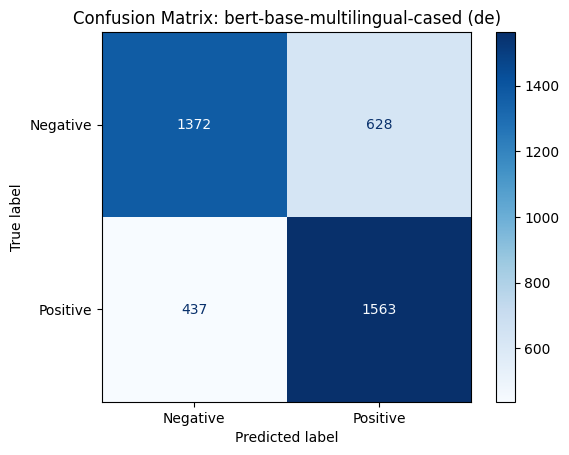



Accuracy: 0.7338
F1 Score: 0.7459
Selection Rate: 0.5477

Fairness Metrics (bert-base-multilingual-cased (de))
Statistical Parity             : 0.5477
Equality of Opportunity        : 0.7815
Calibration (Pos)              : 0.7134
Calibration (Neg)              : 0.7584
Conditional Use Error (P)      : 0.2866
Conditional Use Error (N)      : 0.2416
Treatment Equality (FP/FN)     : 1.4371
Treatment Equality (FN/FP)     : 0.6959


In [31]:
all_labels_de, results_table = test_model(model_de, test_loader_de, "bert-base-multilingual-cased", "de")

# SPANISH

In [32]:
train_loader_es, val_loader_es = prepare_datasets(df_train_es, df_val_es, df_test_es)

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [33]:
model_es = prepare_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [34]:
#train_model(model_es, train_loader_es, val_loader_es, num_epochs, "./best_model_es.pt")

In [35]:
#!zip -r best_model_es.zip /kaggle/working/best_model_es.pt

In [36]:
#FileLink(r'best_model_es.zip')

In [37]:
state_dict = torch.load("/kaggle/input/bert_best_model_es/transformers/default/1/best_model_es.pt")
model_es.load_state_dict(state_dict)

<All keys matched successfully>

In [38]:
test_loader_es = prepare_datasets(None, None, df_test_es, True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 16/16 [02:04<00:00,  7.76s/batch]


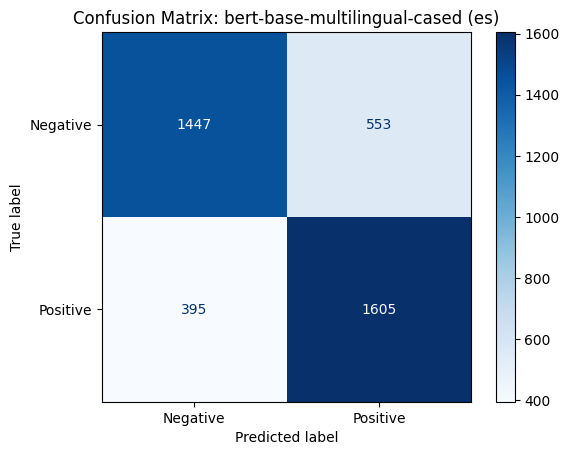



Accuracy: 0.7630
F1 Score: 0.7720
Selection Rate: 0.5395

Fairness Metrics (bert-base-multilingual-cased (es))
Statistical Parity             : 0.5395
Equality of Opportunity        : 0.8025
Calibration (Pos)              : 0.7437
Calibration (Neg)              : 0.7856
Conditional Use Error (P)      : 0.2563
Conditional Use Error (N)      : 0.2144
Treatment Equality (FP/FN)     : 1.4000
Treatment Equality (FN/FP)     : 0.7143


In [39]:
all_labels_es, results_table = test_model(model_es, test_loader_es, "bert-base-multilingual-cased", "es")

# GENERAL MODEL

In [40]:
train_loader, val_loader = prepare_datasets(df_train, df_val, df_test)

Map:   0%|          | 0/479978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11998 [00:00<?, ? examples/s]

In [41]:
model = prepare_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight
classifier.bias


In [42]:
#train_model(model, train_loader, val_loader, num_epochs, "./best_model.pt")

In [43]:
#!zip -r best_model.zip /kaggle/working/best_model.pt

In [44]:
#FileLink(r'best_model.zip')

In [45]:
state_dict = torch.load("/kaggle/input/best_model/transformers/default/1/best_model.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [46]:
test_loader = prepare_datasets(None, None, df_test, True)
test_loader_en = prepare_datasets(None, None, df_test_en, True)
test_loader_es = prepare_datasets(None, None, df_test_es, True)
test_loader_de = prepare_datasets(None, None, df_test_de, True)

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 47/47 [06:12<00:00,  7.92s/batch]


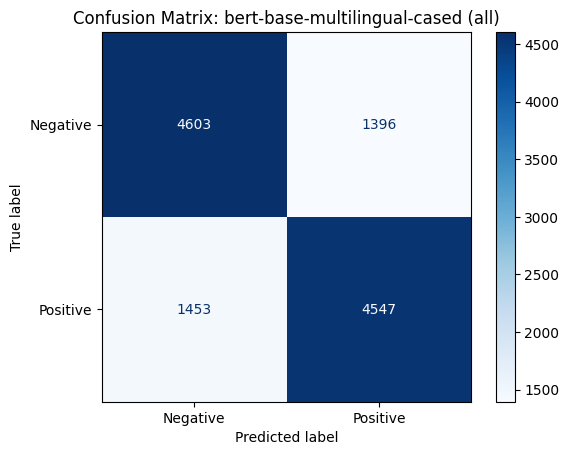



Accuracy: 0.7626
F1 Score: 0.7615
Selection Rate: 0.4953

Fairness Metrics (bert-base-multilingual-cased (all))
Statistical Parity             : 0.4953
Equality of Opportunity        : 0.7578
Calibration (Pos)              : 0.7651
Calibration (Neg)              : 0.7601
Conditional Use Error (P)      : 0.2349
Conditional Use Error (N)      : 0.2399
Treatment Equality (FP/FN)     : 0.9608
Treatment Equality (FN/FP)     : 1.0408


In [47]:
all_labels, results_table = test_model(model, test_loader, "bert-base-multilingual-cased")

Evaluating: 100%|██████████| 16/16 [02:03<00:00,  7.74s/batch]


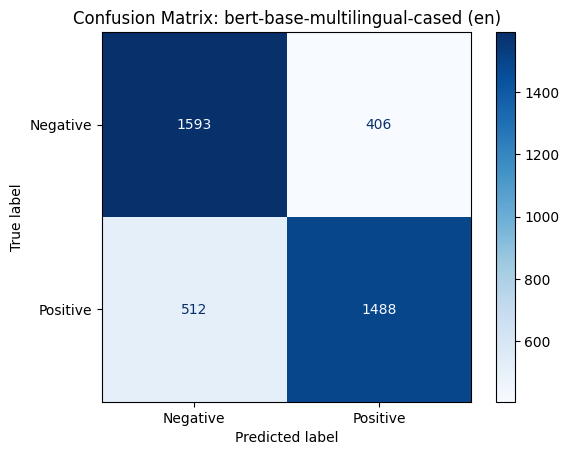



Accuracy: 0.7704
F1 Score: 0.7643
Selection Rate: 0.4736

Fairness Metrics (bert-base-multilingual-cased (en))
Statistical Parity             : 0.4736
Equality of Opportunity        : 0.7440
Calibration (Pos)              : 0.7856
Calibration (Neg)              : 0.7568
Conditional Use Error (P)      : 0.2144
Conditional Use Error (N)      : 0.2432
Treatment Equality (FP/FN)     : 0.7930
Treatment Equality (FN/FP)     : 1.2611


In [48]:
all_labels_en, results_table_en = test_model(model, test_loader_en, "bert-base-multilingual-cased", "en")

Evaluating: 100%|██████████| 16/16 [02:04<00:00,  7.75s/batch]


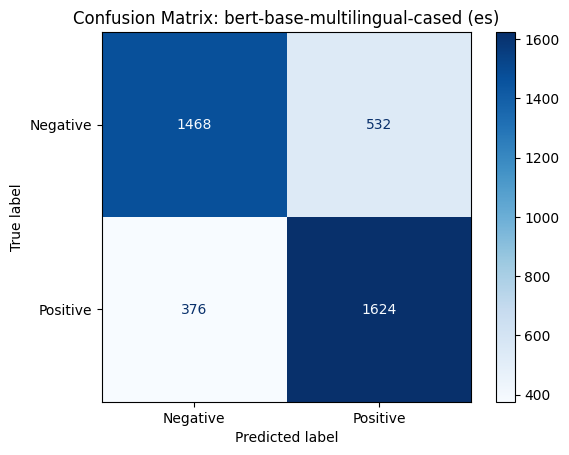



Accuracy: 0.7730
F1 Score: 0.7815
Selection Rate: 0.5390

Fairness Metrics (bert-base-multilingual-cased (es))
Statistical Parity             : 0.5390
Equality of Opportunity        : 0.8120
Calibration (Pos)              : 0.7532
Calibration (Neg)              : 0.7961
Conditional Use Error (P)      : 0.2468
Conditional Use Error (N)      : 0.2039
Treatment Equality (FP/FN)     : 1.4149
Treatment Equality (FN/FP)     : 0.7068


In [49]:
all_labels_es, results_table_es = test_model(model, test_loader_es, "bert-base-multilingual-cased", "es")

Evaluating: 100%|██████████| 16/16 [02:04<00:00,  7.75s/batch]


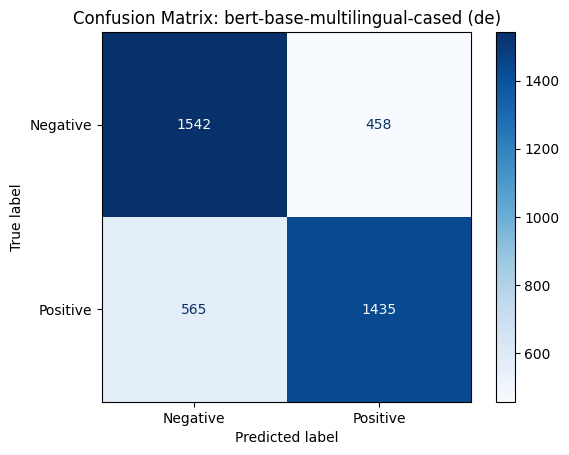



Accuracy: 0.7442
F1 Score: 0.7372
Selection Rate: 0.4733

Fairness Metrics (bert-base-multilingual-cased (de))
Statistical Parity             : 0.4732
Equality of Opportunity        : 0.7175
Calibration (Pos)              : 0.7581
Calibration (Neg)              : 0.7318
Conditional Use Error (P)      : 0.2419
Conditional Use Error (N)      : 0.2682
Treatment Equality (FP/FN)     : 0.8106
Treatment Equality (FN/FP)     : 1.2336


In [50]:
all_labels_de, results_table_de = test_model(model, test_loader_de, "bert-base-multilingual-cased", "de")